# Assing existence: a first step in isolating the complex
In this notebook we will take a look at what it means to "assess existence" (or, perhaps more precisely "assess causality") in IIT. Following the introduction given of the [postulate](link) and on the [unfolding page](link), we will explore the following concepts:

1) basic properties of the transition probability matrix (TPM)
2) what is meant by conditional independence of the units 
3) how to obtain constrained and unconstrained probabilities from the TPM
4) how to compute causal informativeness
5) how we can use the causal informativeness to assess existence in its most basic form

Let's go!

<img src="figures/Panel_1.jpg" width=500/>

## Import packages
The first thing to do is import the packages we will need

In [29]:
import pyphi
from tutorial_functions import visualization as viz
from tutorial_functions import utils
import numpy as np


In [4]:
%load_ext blackcellmagic
%load_ext autoreload

%matplotlib inline
%autoreload 2

## Create the substrate
Next, let's use the built-in functionality of pyphi to create the substrate from figure 1 of [the IIT 4.0 paper](https://arxiv.org/abs/2212.14787)

In [5]:
# give names to the units
node_labels = ["A","B","C"]

# set the strength of connectivity between units
connectivity = np.array(
    [
        [-.2,0.7,0.2],
        [0.7,-.2,0.0],
        [0.0,-.8,0.2]        
    ]
)

# set the level of determinism for the units' activation function 
determinism = 4

# build the network
substrate = pyphi.network_generator.build_network(
    [pyphi.network_generator.ising.probability]*len(node_labels),
    connectivity,
    temperature=1/determinism,
    node_labels=node_labels
)


### Inspect the substrate TPM
We can now simply inspect the TPM of the substrate and start exploring its properties

In [8]:
TPM = viz.state_by_state_tpm(substrate)
TPM.round(3)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.170,0.023,0.563,0.076,0.034,0.005,0.114,0.015
1,0,0,0.001,0.000,0.486,0.013,0.001,0.000,0.486,0.013
0,1,0,0.013,0.485,0.009,0.325,0.003,0.098,0.002,0.066
1,1,0,0.000,0.002,0.059,0.438,0.000,0.002,0.059,0.438
0,0,1,0.438,0.059,0.002,0.000,0.438,0.059,0.002,0.000
1,0,1,0.066,0.002,0.098,0.003,0.325,0.009,0.485,0.013
0,1,1,0.013,0.486,0.000,0.001,0.013,0.486,0.000,0.001


---
Each of these numbers indicate the probability that the substrate will transition from an input state (left) to an output state (top).

For example, we can see that the substrate has about a 50% probability of transitioning to (0,1,0) if it was in state (1,0,0).

In [9]:
input_state = (1,0,0)
output_state = (0,1,0)

viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


We can also get at this conditional probability, by indexing into TPM directly

In [10]:
P = TPM[input_state][output_state]
print('Probability of transitioning from {} to {} is {}'.format(
    input_state,output_state,P.round(3)
))

Probability of transitioning from (1, 0, 0) to (0, 1, 0) is 0.485


You may notice that the TPM is normalized such that each row sums to exactly 1. This is because the substrate will necessarily transition to *some* state, whatever its starting point (input state) might be. In other words, the substrate has a 100% chance of transitioning to one of its available output states. 

In [11]:
TPM.sum(axis=1)

A  B  C
0  0  0    1.0
1  0  0    1.0
0  1  0    1.0
1  1  0    1.0
0  0  1    1.0
1  0  1    1.0
0  1  1    1.0
1  1  1    1.0
dtype: float64

Given the input state, the way the probabilities are distributed across the possible output states can be visualized by a bar chart:

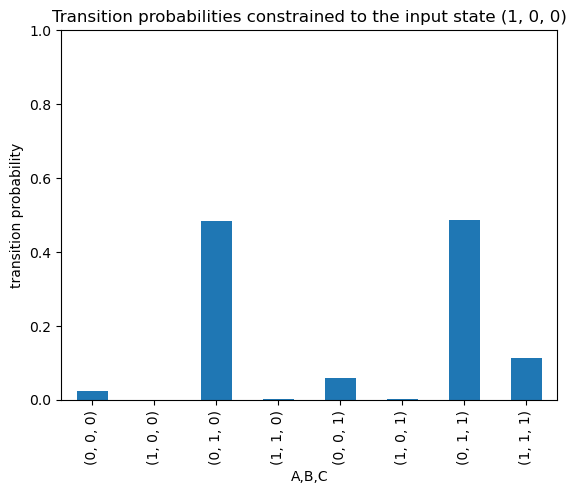

In [12]:
TPM[input_state].plot.bar(
    ylabel='transition probability', 
    ylim=[0,1], 
    title='Transition probabilities constrained to the input state {}'.format(input_state)
);

We often refer to the conditional probabilities in the TPM as the *constrained probabilities*. This is because they indicate the probability of seeing a particular output state next, given (or constrained to the knowledge) that the input state was what it was. This is to contrast it to the *un*constrained probabilities (which we will see later), that tell us about the probabilities of observing some outputstate independently of what the input state was.  

## Conditional independence
While it might seem natural to look at this square "state-by-state" representation of the TPM, it hides a crucial fact about TPMs in IIT: the units are conditionally independent! This means that, given the knowledge of what the input state of a substrate was, the output state of each unit is *independent* of the output state of the other units. 

Lets explore this fact with the inbuilt functionality of pyphi.

In [13]:
# set an input state for the substrate
input_state = (1,0,0)

# print the values stored in the pyphi tpm when we provide it with the input state
substrate.tpm[input_state]

ExplicitTPM([0.02659699 0.99888746 0.5       ])

These numbers just represent the probability of each of the three units (A, B and C) bein ON in the output state. For example, unit A (represented by the first number) is almost guaranteed to be OFF (because P(ON)=0.027, and P(OFF)=1-P(ON)). Similarly, unit B is almost guaranteed to be ON, and unit C is completely undetermined: it is 50/50 whether it turns ON or OFF. 
Thus, we can see that all three units are indeterministic (none of the values are exactly 0 or 1), and while it is not explicit in the numbers, there is no dependence between what state unit A (first number) happens to take on and which state the other units will take on; each unit will just update according to their own probability. 
---
Furthermore, you might notice that we can derive the exact probabilities we saw in the previous "state-by-state"-representation of the TPM by using multiplication of these probabilities. For example, the probability of the substrate's overall output state is ON, ON, ON is just equal to the product of the three probabilities above. This is a direct consequence of the conditional independence.

In [14]:
def substrate_probability_from_unit_probabilities(substrate,input_state, output_state):
    return np.prod([
        p if unit_output==1 else 1-p 
        for unit_output, p in zip(output_state,substrate.tpm[input_state])
    ])

input_state = (1,0,1)
output_state = (1,1,1)
P_from_units = substrate_probability_from_unit_probabilities(substrate,input_state, output_state)
P_from_units

0.01324847157151889

Compare this probability to the one we have from the state-by-state TPM

In [15]:

viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


This is true for any combination of input and output states: the the conditional probabilities in the state-by-state (square) TPM are always found by taking the product of probabilities from the state-by-node TPM. try it out!

In [16]:

# choose some input and output states
input_state = (1,1,1)
output_state = (1,1,1)

# compute probaility of the ooutput state happening from both TPM representations
P_from_units = substrate_probability_from_unit_probabilities(substrate,input_state, output_state)
P_from_statebystate = TPM[output_state][input_state]

# check if they are the same
P_from_units == P_from_statebystate

True

In fact, it might be best to think of the TPM primarily in its state-by-node form. As that makes it easier to consider the units as conditionally independent. 

In [19]:
viz.state_by_node_tpm(substrate)

,,,A ON,B ON,C ON
A,B,C,,,
0,0,0,0.119203,0.768525,0.167982
1,0,0,0.026597,0.998887,0.500000
0,1,0,0.973403,0.401312,0.167982
1,1,0,0.880797,0.994514,0.500000
0,0,1,0.119203,0.005486,0.500000
1,0,1,0.026597,0.598688,0.832018
0,1,1,0.973403,0.001113,0.500000
1,1,1,0.880797,0.231475,0.832018


Each column in this TPM shows the probability of the corresponding (binary) unit turning *ON*. In fact, we might just as well consider each column independently as a "unit TPM" for its corresponding unit.  

In [23]:
viz.unit_tpm(substrate,'B')

,,,B ON
A,B,C,
0,0,0,0.768525
1,0,0,0.998887
0,1,0,0.401312
1,1,0,0.994514
0,0,1,0.005486
1,0,1,0.598688
0,1,1,0.001113
1,1,1,0.231475


The perceptive reader might have spotted that unit C seems to be behaving a bit strangely: the values in its unit TPM seem to repeat in a structured manner.

In [36]:
viz.unit_tpm(substrate,'C')

,,,C ON
A,B,C,
0,0,0,0.167982
1,0,0,0.500000
0,1,0,0.167982
1,1,0,0.500000
0,0,1,0.500000
1,0,1,0.832018
0,1,1,0.500000
1,1,1,0.832018


This is because it only receives inputs from two out of the three units in the substrate.

In [37]:
utils.possible_inputs(substrate, 'C')

['A', 'C']

Still, it is useful to keep the full set of input states in the TPM, for completeness sake. Let's move on to the next section.

## Constrained and unconstrained probabilities

## Computing informativeness

## Using informativeness to "assess existence"

In [92]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: bold; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: lightblue; color: black;'
}
TPM.style.set_table_styles([cell_hover, index_names, headers])

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.170000,0.023000,0.563000,0.076000,0.034000,0.005000,0.114000,0.015000
1,0,0,0.001000,0.000000,0.486000,0.013000,0.001000,0.000000,0.486000,0.013000
0,1,0,0.013000,0.485000,0.009000,0.325000,0.003000,0.098000,0.002000,0.066000
1,1,0,0.000000,0.002000,0.059000,0.438000,0.000000,0.002000,0.059000,0.438000
0,0,1,0.438000,0.059000,0.002000,0.000000,0.438000,0.059000,0.002000,0.000000
1,0,1,0.066000,0.002000,0.098000,0.003000,0.325000,0.009000,0.485000,0.013000
0,1,1,0.013000,0.486000,0.000000,0.001000,0.013000,0.486000,0.000000,0.001000
